C:\Users\garik\AppData\Local\Temp\ipykernel_18892\1508486741.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


Number of training samples: 9317
Number of testing samples: 2330
Reloading Tuner from hyperband_dir\vision_transformer_tuning\tuner0.json
Epoch 1/50
43/72 ━━━━━━━━━━━━━━━━━━━━ 5:59 12s/step - accuracy: 0.1695 - loss: 2.5523

C:\Users\garik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 1029s 14s/step - accuracy: 0.2148 - loss: 2.4034 - val_accuracy: 0.4353 - val_loss: 1.6954 - learning_rate: 1.2195e-04
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 996s 13s/step - accuracy: 0.4947 - loss: 1.5565 - val_accuracy: 0.5436 - val_loss: 1.3809 - learning_rate: 1.2195e-04
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 23977s 337s/step - accuracy: 0.5841 - loss: 1.2726 - val_accuracy: 0.5931 - val_loss: 1.2866 - learning_rate: 1.2195e-04
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1128s 16s/step - accuracy: 0.6516 - loss: 1.0718 - val_accuracy: 0.6240 - val_loss: 1.1893 - learning_rate: 1.2195e-04
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2956s 41s/step - accuracy: 0.6979 - loss: 0.9175 - val_accuracy: 0.6135 - val_loss: 1.2742 - learning_rate: 1.2195e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 928s 13s/step - accuracy: 0.7424 - loss: 0.7958 - val_accuracy: 0.6485 - val_loss: 1.1561 - learning_rate: 1.2195e-04
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 900s 12s/step - accuracy: 0.781

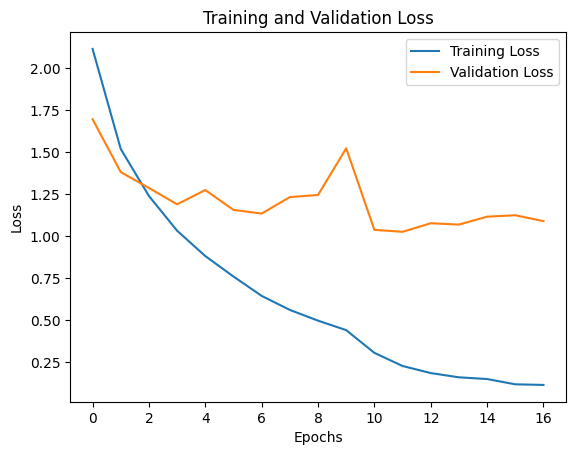

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from kerastuner.tuners import Hyperband
import matplotlib.pyplot as plt

# Define the path to the dataset
dataset_path = r"D://SEM-4//PROJECTS//ML//DATASET//Archive"

# Get file paths and labels from folder structure
file_paths = []
labels = []

for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        for img_file in os.listdir(label_path):
            file_paths.append(os.path.join(label_path, img_file))
            labels.append(label)

# Convert labels to numerical format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(file_paths, labels_encoded, test_size=0.2, random_state=42)

# Print the number of samples
print(f'Number of training samples: {len(X_train)}')
print(f'Number of testing samples: {len(X_test)}')

# Function to preprocess images
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator with augmentation
def augmented_data_generator(file_paths, labels, batch_size=128):
    while True:
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = np.vstack([preprocess_image(path) for path in batch_paths])
            augmented_images = next(datagen.flow(batch_images, batch_size=batch_size, shuffle=False))
            yield augmented_images, np.array(batch_labels)

# Create a Vision Transformer model with fine-tuning
def create_vision_transformer(hp):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[-10:]:
        layer.trainable = True  # Unfreeze the last 10 layers

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(hp['units_1'], activation='relu')(x)
    x = layers.Dropout(hp['dropout_1'])(x)
    x = layers.Dense(hp['units_2'], activation='relu')(x)
    x = layers.Dropout(hp['dropout_2'])(x)
    outputs = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp['learning_rate']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Load the best hyperparameters from the hyperband directory
tuner = Hyperband(
    create_vision_transformer,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband_dir',
    project_name='vision_transformer_tuning'
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
vit_model = tuner.hypermodel.build(best_hps)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = vit_model.fit(augmented_data_generator(X_train, y_train, batch_size=128), 
                        steps_per_epoch=len(X_train)//128,
                        epochs=50, 
                        validation_data=augmented_data_generator(X_test, y_test, batch_size=128),
                        validation_steps=len(X_test)//128, 
                        callbacks=[reduce_lr, early_stopping])

# Evaluate the model
test_loss, test_acc = vit_model.evaluate(augmented_data_generator(X_test, y_test, batch_size=128), steps=len(X_test)//128)
print(f'Test accuracy: {test_acc}')

# Print final training and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f'Final Training Accuracy: {train_acc}')
print(f'Final Validation Accuracy: {val_acc}')

# Predict and evaluate results
y_pred = vit_model.predict(augmented_data_generator(X_test, y_test, batch_size=128), steps=len(X_test)//128)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test[:len(y_pred_classes)], y_pred_classes))
print(confusion_matrix(y_test[:len(y_pred_classes)], y_pred_classes))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
